In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('C:\\Users\\Admin\\Downloads\\ACB.csv')
df1=df.reset_index()['Close']
df1 = df[['Close']]

In [3]:
# 3. Scaler data
df1['Close'] = df1['Close'].str.replace(',', '')
df1['Close'] = df1['Close'].astype(float)
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(df1.values.reshape(-1, 1))

C:\Users\Admin\AppData\Local\Temp\ipykernel_6988\3126230850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Close'] = df1['Close'].str.replace(',', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_6988\3126230850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Close'] = df1['Close'].astype(float)


In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

IndexError: tuple index out of range

In [8]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

15/15 [==============================] - 5s 100ms/step - loss: 0.2898 - val_loss: 0.0069
Epoch 2/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 3/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 4/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0015 - val_loss: 0.00

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

11/11 [==============================] - 0s 9ms/step


ValueError: Expected input data to be non-empty.

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 13049.486468710187
Testing RMSE: 11624.011301595356


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=90
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.13438883]
91
[0.13438883]
92
[0.13438883]
93
[0.13438883]
94
[0.13438883]
95
[0.13438883]
96
[0.13438883]
97
[0.13438883]
98
[0.13438883]
99
[0.13438883]
100
[0.13438883]
101
11 day input [0.24989235 0.272766   0.26971463 0.2651399  0.24074288 0.271238
 0.28649019 0.29563502 0.25904181 0.25751844 0.23464479 0.24074288
 0.21329913 0.271238   0.272766   0.32765814 0.32155541 0.33985433
 0.34900379 0.3352796  0.33375623 0.35510189 0.33833096 0.36425135
 0.37340081 0.37034945 0.35357852 0.34290569 0.3413777  0.34442906
 0.30630785 0.30478448 0.30935921 0.31850867 0.31545731 0.29563502
 0.31088258 0.32460677 0.33223287 0.31088258 0.29286611 0.27900301
 0.27622946 0.27622946 0.26791345 0.2429608  0.22217077 0.22078632
 0.23048678 0.20414967 0.23880279 0.23187587 0.24573434 0.23741833
 0.22217077 0.21385477 0.20692322 0.21108122 0.19999167 0.1764281
 0.14731744 0.14177498 0.15840699 0.13345434 0.14870653 0.16949655
 0.162565   0.17227009 0.17088101 0.1764281  0.17781256 0.17365455
 0.16395

ValueError: cannot reshape array of size 100 into shape (1,90,1)

ValueError: x and y must have same first dimension, but have shapes (30,) and (11, 1)

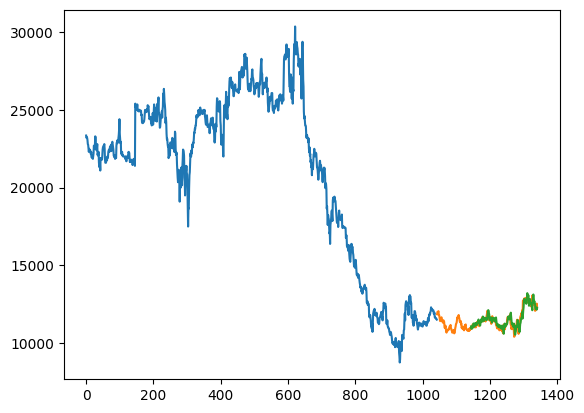

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output))
plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()